In [0]:
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

In [0]:
#since each feature (value) in a sample has a different range, take the mean of each column
#and subtract it from each value in the column, then divide the standard deviation

mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

#quantities used for normalizing the test data are computed using the training data!
test_data -= mean
test_data /= std

In [0]:
# the less data available the worse the overfitting will be, so a small network is used to mitigate the potential problem

from keras import models
from keras import layers

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1)) #the neural network ends with a single unit w/ no activation. 
    #typical setup for scalar regression (when trying to predict a single continuous value) like house price in this case
    #the network is not confined to output a value within a range (in the case of a sigmoid function)
    
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae']) #mse is a popular loss function for regression
    return model

In [44]:
#since the training data is small, just splitting the data into training and validation will create a large variance in validations scores
#to combat this, k-fold cross-validation will be used

import numpy as np

k = 4
num_val_samples = len(train_data) // k #floor division
num_epochs = 500
all_scores = []
all_mae_histories = []

for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples], 
         train_data[(i + 1) * num_val_samples:]],
        axis = 0)
    
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis = 0)
    
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets, epochs = num_epochs, batch_size = 1, verbose = 0, validation_data=(val_data, val_targets))
    #val_mse, val_mae = model.evaluate(val_data, val_targets, verbose = 0)
    #print(history.history.keys())
    mae_history = history.history['val_mean_absolute_error']
    #all_scores.append(val_mae)
    all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [45]:
print(all_mae_histories)

[[3.8703383455182068, 3.2232520981590347, 2.889679710463722, 2.666090785866917, 2.7492465311937995, 2.4214577910923722, 2.3146840652616896, 2.200061495941464, 2.2371333093926458, 1.9828576711144779, 2.096217740880381, 2.130563178865036, 1.9082746128044505, 2.0478050024202554, 2.1414429976208376, 2.1179609865245252, 2.3670594904682423, 2.1330427509723324, 2.176488404226775, 1.93599005028753, 2.0192226372142827, 1.8863308594958617, 2.1524263797420087, 2.1659874019056264, 2.2863546409229243, 2.0079193115234375, 1.9732889420915358, 1.877917714638285, 2.3924814356435644, 1.8199984814861032, 1.8808668485962519, 1.910690978021905, 1.9376439009562578, 2.408101270694544, 1.897024966702603, 1.9482842719200815, 1.788577924860586, 2.2382643671319036, 1.8138980771055315, 1.9792795370120813, 1.891354216207372, 2.0264037292782624, 1.8346005902431979, 1.9741733947602829, 1.8532117050473054, 1.8591294807962853, 1.893629527328038, 1.9894537689662215, 1.885427748802865, 2.3749364720712793, 1.850075816163

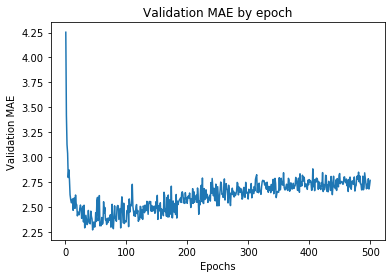

In [46]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

import matplotlib.pyplot as plt

plt.title("Validation MAE by epoch")
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

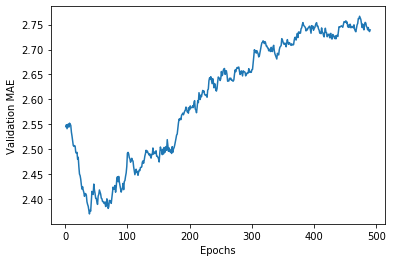

In [47]:
#replace first 10 data points because they are using a different scale
#replace each point with an exponential moving average of the previous points to obtain a smooth curve

def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point *(1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [48]:
model = build_model()
model.fit(train_data, train_targets, epochs = 80, batch_size = 16, verbose = 0)

test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

102/102 [==============================] - 0s 5ms/step


In [49]:
print(test_mse_score, test_mae_score)

16.930333006615733 2.763639945609897
